In [1]:
import numpy as np
np.random.seed(13)

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import skipgrams
from IPython.display import Image
import random

import gensim

Using TensorFlow backend.


In [2]:
def skipgrams(sequence, vocabulary_size,
              window_size=4, negative_samples=1., shuffle=True,
              categorical=False, sampling_table=None, seed=None):
    couples = []
    labels = []
    for i, wi in enumerate(sequence):
        if not wi:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = sequence[j]
                if not wj:
                    continue
                couples.append([wi, wj])
                if categorical:
                    labels.append([0, 1])
                else:
                    labels.append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [[words[i % len(words)],
                    random.randint(1, vocabulary_size - 1)]
                    for i in range(num_negative_samples)]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples

    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)
        
    return couples, labels

In [3]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
corpus = open(path).readlines()

corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
V = len(tokenizer.word_index) + 1
V

3388

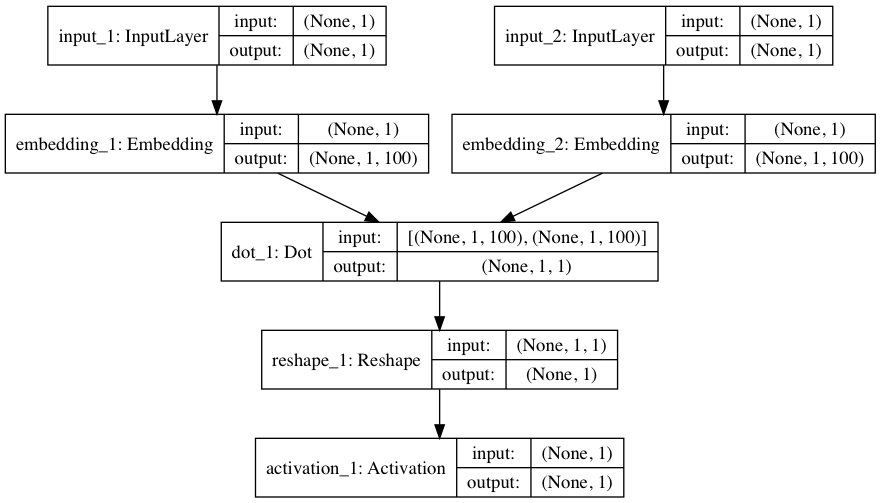

In [4]:
embedding_dim = 100

# inputs
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, embedding_dim)(w_inputs)

# context
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, embedding_dim)(c_inputs)
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)
o = Activation('sigmoid')(o)

ft_model = Model(inputs=[w_inputs, c_inputs], outputs=o)
# ft_model.summary()
ft_model.compile(loss='binary_crossentropy', optimizer='adam')

Image(model_to_dot(ft_model, show_shapes=True).create(prog='dot', format='png'))

In [5]:
for _ in range(5):
    loss = 0.
    for i, doc in enumerate(tokenizer.texts_to_sequences(corpus)):
        data, labels = skipgrams(sequence=doc, vocabulary_size=V, window_size=5, negative_samples=5.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss += ft_model.train_on_batch(x, y)

    print(loss)


1099.483755685389
752.0379249565303
695.713611856103
668.0206193439662
646.2427548915148


In [6]:
with open('vectors.txt' ,'w') as f:
    f.write('{} {}\n'.format(V-1, embedding_dim))
    vectors = ft_model.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))

In [7]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [8]:
w2v.most_similar(positive=['queen'])

[('king', 0.7407128214836121),
 ('gryphon', 0.7141942977905273),
 ('knave', 0.7021409273147583),
 ('hearts', 0.6955883502960205),
 ('the', 0.6753973960876465),
 ('mock', 0.6735886931419373),
 ('followed', 0.6733502149581909),
 ('tarts', 0.6621636152267456),
 ('turning', 0.6600418090820312),
 ('those', 0.6586543321609497)]

In [9]:
w2v.most_similar(positive=['alice'])

[('rather', 0.6660013794898987),
 ('thought', 0.6603125333786011),
 ('cautiously', 0.6065048575401306),
 ('‘i’m', 0.5982785224914551),
 ('hastily', 0.5808516144752502),
 ('‘but', 0.5779058933258057),
 ('glad', 0.5732821226119995),
 ('child', 0.5606131553649902),
 ('afraid', 0.5593591928482056),
 ('curious', 0.5558264255523682)]

In [10]:
w2v.most_similar(positive=['the'])

[('queen', 0.6753973960876465),
 ('mock', 0.6573097109794617),
 ('laws', 0.6515294909477234),
 ('king', 0.6311447620391846),
 ('those', 0.6289721727371216),
 ('hearts', 0.5974344611167908),
 ('outside', 0.5931041836738586),
 ('turtle', 0.5929770469665527),
 ('foundation’s', 0.5915161967277527),
 ('gryphon', 0.5719778537750244)]